# Config and Imports

In [1]:
import os
os.chdir('../../')
prj_path = "./data/IGs/"
print(os.getcwd())

c:\Users\andri\Progetti\igraph_transformer


In [41]:
import random

import torch
import pickle
import torch.utils.data
import time
import os
import numpy as np

import csv

import dgl

from scipy import sparse as sp
import networkx as nx
import hashlib

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torch.utils.data import SubsetRandomSampler, DataLoader
from collections import defaultdict
from data.IGs_V2 import IGsDatasetDGL

# Prepare dataset

txt --> train/test/val PKL: NO DGL

In [42]:
data_list = []
dataset = []

#data_path = prj_path + 'ig_subgraphs.txt'
with open(prj_path + 'ig_subgraphs_no_duplicates.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove whitespace and newline characters
        values = line.split(']')  # Split the line based on the ']' character
        nums = values[0].strip('[, ')  # Extract the numbers inside the square brackets
        nums = [int(num) for num in nums.split(',')]  # Convert the numbers into a list of integers
        num_after_bracket = int(values[1].strip())  # Extract the number after the square bracket
        data_list.append([nums, num_after_bracket])

random.shuffle(data_list)

G = nx.Graph()

for data in data_list:
  nodes, label = data[:2]
  edges = [(nodes[i], nodes[i+1]) for i in range(len(nodes)-1)]

  G.clear()  # Svuota il grafo precedente
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)

  obj = (G.copy(), int(label))
  dataset.append(obj)
  
with open(prj_path + 'igraph-GTN.pkl', 'wb') as f:
  pickle.dump(dataset, f)

In [43]:
# dataset = [data for data in dataset if data[1] != 15]
len(dataset)

13811

### Split and Dump train,val,test pkl

In [26]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Subset
#-------------------------------TRAIN-----------------------------
seed = 10
random.seed(seed)
torch.manual_seed(seed)

train_p = 0.9 # Train set percentage
num_samples = len(dataset)
train_samples = int(train_p * num_samples)

targets = [data[1] for data in dataset]


# Calculate the frequency of each class and get the weights for each class
class_counts = torch.bincount(torch.tensor(targets))
class_weights = torch.true_divide(1.0, class_counts)

# Normalize the class weights
# class_weights /= torch.max(class_weights)

# Create a tensor of class labels
targets = torch.tensor(torch.tensor(targets))


# WeightedRandomSampler for weight based sampling with replacement
sampler = WeightedRandomSampler(class_weights[targets], train_samples, replacement=True)

train_indices = list(sampler)

# Use the sampler to sample the dataset for the trainset
train = torch.utils.data.Subset(dataset, train_indices)

#-------------------------------TEST/VAL-----------------------------
# Create a subset of the dataset excluding the train indices
remaining_indices = list(set(range(len(dataset))) - set(train_indices))

test_p = 0.2 # % of the remaining samples
test_size = int(test_p * num_samples)
test_indices = random.sample(remaining_indices, test_size)

# Create the test set with the sampled indices
test = Subset(dataset, test_indices)

# Create a subset of the dataset excluding the train and test indices
val_indices = list(set(range(len(dataset))) - set(train_indices) - set(test_indices))

# Create the test set with the sampled indices
val = Subset(dataset, val_indices)
print(len(train), len(test), len(val))

12429 2762 5677


c:\Users\andri\miniconda3\envs\graph_transformer\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [46]:
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit

import random
import torch
import numpy as np

from collections import defaultdict

#-------------------------------TRAIN/TEST/VAL SPLIT-----------------------------
seed = 10
random.seed(seed)
torch.manual_seed(seed)

train_p = 0.70  # Train set percentage
test_p = 0.15  # Test set percentage
val_p = 0.15 # Validation set percentage

num_samples_train = int(train_p * len(dataset))
# Use StratifiedKFold to split the data into train and test sets stratifically
sss_train_test = StratifiedShuffleSplit(n_splits=1, train_size=num_samples_train, random_state=seed)

# Get the data and targets from the dataset
data = [sample[0] for sample in dataset]
targets = [sample[1] for sample in dataset]

# Convert data and targets to numpy arrays
data = np.array(data)
targets = np.array(targets)

for train_index, test_index in sss_train_test.split(data, targets):
    # Split the data into train and test sets
    data_train, data_test = data[train_index], data[test_index]
    targets_train, targets_test = targets[train_index], targets[test_index]
print(f"Train set size: {len(data_train)}")

Train set size: 9667


In [47]:

# Calculate the number of samples for train and validation sets
num_samples_test = int(test_p * len(dataset))
num_samples_val = int(val_p * len(dataset))

# Use StratifiedShuffleSplit to split the train set into train and validation sets
sss_test_val = StratifiedShuffleSplit(n_splits=1, test_size=num_samples_val, random_state=seed)

for test_index, val_index in sss_test_val.split(data_test, targets_test):
    # Split the data_test into test and validation sets
    data_test, data_val = data_test[test_index], data_test[val_index]
    targets_test, targets_val = targets_test[test_index], targets_test[val_index]

# Create the Subset objects for train, test, and validation sets
train = Subset(dataset, train_index)
test = Subset(dataset, test_index)
val = Subset(dataset, val_index)

print(len(train), len(test), len(val))


9667 2073 2071


Total samples in dataset: 9667
class 7: 1804 samples
class 14: 2685 samples
class 10: 1886 samples
class 9: 1417 samples
class 3: 46 samples
class 8: 342 samples
class 4: 54 samples
class 11: 305 samples
class 5: 363 samples
class 12: 401 samples
class 6: 279 samples
class 13: 38 samples
class 15: 38 samples
class 2: 9 samples


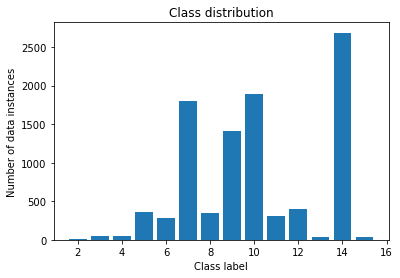

In [50]:
import matplotlib.pyplot as plt
from collections import defaultdict

plt_ds = train

print(f"Total samples in dataset: {len(plt_ds)}")
# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(plt_ds):
    label = data[1]
    class_counts[label] += 1

for key, value in class_counts.items():
    print(f"class {key}: {value} samples")

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title(f'Class distribution')
plt.show()


In [37]:
#train, test_val_data = train_test_split(dataset, test_size=0.3, random_state=42)
#test, val = train_test_split(test_val_data, test_size=0.7, random_state=42)

start = time.time()
with open(prj_path + 'igraph-GTN-v2-train.pkl','wb') as f:
        pickle.dump(train, f)
with open(prj_path + 'igraph-GTN-v2-test.pkl','wb') as f:
        pickle.dump(test, f)
with open(prj_path + 'igraph-GTN-v2-val.pkl','wb') as f:
        pickle.dump(val, f)

print('Time (sec):',time.time() - start)

Time (sec): 0.6290028095245361


# Load Dataset

In [38]:
if not os.path.isfile(prj_path + 'igraph-DatasetDGL-noDup.pkl'):
  # file presente --> pkl load
  # with open(prj_path + 'igraph-DatasetDGL.pkl', "rb") as f:
  #   f = pickle.load(f)
  #   datasetDGL = f
  datasetDGL = IGsDataset()
else:
  # dataset non presente -> generazione
  datasetDGL = IGsDatasetDGL()

  start = time.time()
  with open(prj_path + 'igraph-DatasetDGL-noDup.pkl', 'wb') as f:
          #pickle.dump([datasetDGL.train,datasetDGL.val,datasetDGL.test], f)
          pickle.dump(datasetDGL, f)
  print('Time (sec):',time.time() - start)

[I] Loading data ...
preparing 8978 graphs for the TRAIN set...


c:\Users\andri\miniconda3\envs\graph_transformer\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


preparing 2071 graphs for the VAL set...
preparing 2762 graphs for the TEST set...
[I] Finished loading.
Time taken: 192.3950s
Time (sec): 5.984982967376709


In [16]:
datasetDGL.train[1][0]

Graph(num_nodes=16, num_edges=30,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})

### Explore dataset

In [17]:
print(len(datasetDGL.train))
print(len(datasetDGL.val))
print(len(datasetDGL.test))

print(datasetDGL.train[0])
print(datasetDGL.val[0])
print(datasetDGL.test[0])

9631
1375
2751
(Graph(num_nodes=15, num_edges=24,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(14))
(Graph(num_nodes=7, num_edges=8,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(12))
(Graph(num_nodes=14, num_edges=16,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(6))


In [39]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(test):
    label = data['target']
    class_counts[label.item()] += 1

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title('Class distribution for test set')
plt.show()


TypeError: tuple indices must be integers or slices, not str

In [7]:
# Create set of unique classes in train set
unique_classes = set()
for data in train:
    label = data['target']
    unique_classes.add(label.item())

# Count number of unique classes
num_classes = len(unique_classes)
print("Number of unique classes in train set: ", num_classes)
print(unique_classes)

NameError: name 'train' is not defined

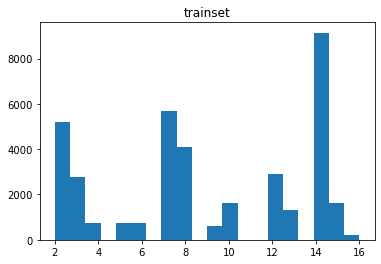

min/max : 2 16


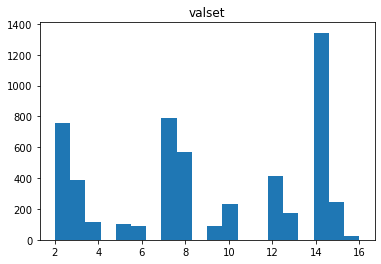

min/max : 2 16


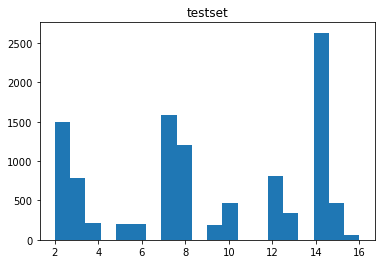

min/max : 2 16


In [93]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())

plot_histo_graphs(datasetDGL.train,'trainset')
plot_histo_graphs(datasetDGL.val,'valset')
plot_histo_graphs(datasetDGL.test,'testset')

# Test

In [50]:
train[0]

{'num_node': 14,
 'node_type': tensor([0, 1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=torch.int8),
 'adj': tensor([[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]], dtype=torch.int8),
 'target': tensor(6)}

In [68]:
datasetDGL.train[0][1].item()


6